In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader as pdr
%matplotlib inline

In [13]:
aapl = pdr.get_data_google('AAPL', '2012-08-01', '2017-01-01')

In [14]:
aapl.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-08-01,87.99,88.06,86.14,86.69,96124742
2012-08-02,86.12,87.24,85.75,86.83,83062203
2012-08-03,87.66,88.28,87.37,87.96,86228604
2012-08-06,88.18,89.27,87.89,88.94,75580008
2012-08-07,88.97,89.29,88.29,88.70,72627492


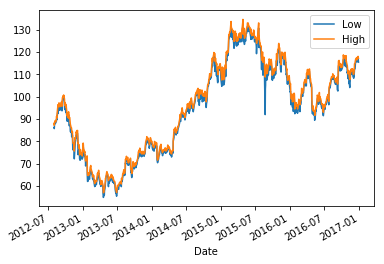

In [20]:
aapl[['Low', 'High']].plot()

In [43]:
symbols = ['SPY', 'GOOG', 'IBM', 'GLD']

In [52]:
df = pd.DataFrame()
for symbol in symbols:
    df_temp = pdr.get_data_google(symbol, '2010-01-01', '2012-01-01')
    df_temp.rename(columns={'Close': symbol}, inplace=True)
    df = df.join(df_temp[symbol], how='outer')
df.head()

,SPY,GOOG,IBM,GLD
Date,,,,
2010-01-04,113.33,313.06,132.45,109.80
2010-01-05,113.63,311.68,130.85,109.70
2010-01-06,113.71,303.83,130.00,111.51
2010-01-07,114.19,296.75,129.55,110.82
2010-01-08,114.57,300.71,130.85,111.37


In [57]:
df['2010-01-04':'2010-01-10',['GOOG']]

TypeError: unhashable type: 'slice'